## 📦 Section 1: Setup & Imports

First, we install and import all necessary libraries for:
- **PyTorch**: Deep learning framework
- **torchaudio**: Audio processing
- **librosa**: Additional audio analysis
- **sklearn**: Evaluation metrics
- **matplotlib/seaborn**: Visualization

In [1]:
# =============================================================================
# 📦 INSTALL DEPENDENCIES
# =============================================================================
import subprocess
import sys

packages = [
    'torch', 'torchaudio', 'librosa', 'numpy', 'pandas', 
    'scikit-learn', 'matplotlib', 'seaborn', 'soundfile',
    'imageio-ffmpeg'
]

for package in packages:
    pkg_name = package.replace('-', '_') if package == 'scikit-learn' else package
    try:
        __import__(pkg_name.replace('-', '_'))
        print(f"✅ {package} already installed")
    except ImportError:
        print(f"📦 Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
        print(f"✅ {package} installed")

print("\n✅ All dependencies ready!")

✅ torch already installed
📦 Installing torchaudio...
✅ torchaudio installed
✅ librosa already installed
✅ numpy already installed
📦 Installing pandas...
✅ torchaudio installed
✅ librosa already installed
✅ numpy already installed
📦 Installing pandas...
✅ pandas installed
📦 Installing scikit-learn...
✅ pandas installed
📦 Installing scikit-learn...
✅ scikit-learn installed
✅ scikit-learn installed
✅ matplotlib already installed
📦 Installing seaborn...
✅ matplotlib already installed
📦 Installing seaborn...
✅ seaborn installed
✅ soundfile already installed
✅ imageio-ffmpeg already installed

✅ All dependencies ready!
✅ seaborn installed
✅ soundfile already installed
✅ imageio-ffmpeg already installed

✅ All dependencies ready!


In [2]:
# =============================================================================
# 📚 IMPORT LIBRARIES
# =============================================================================
import os
import json
import random
import warnings
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any

# Numerical & Data
import numpy as np
import pandas as pd

# Audio Processing
import librosa
import soundfile as sf

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [3]:
# =============================================================================
# 🖥️ GPU DETECTION & REPRODUCIBILITY
# =============================================================================

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# GPU Detection
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"🚀 GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    DEVICE = torch.device('cpu')
    print("⚠️ GPU not available, using CPU")

print(f"\n📱 Device: {DEVICE}")
print(f"🔧 PyTorch Version: {torch.__version__}")

⚠️ GPU not available, using CPU

📱 Device: cpu
🔧 PyTorch Version: 2.9.1+cpu


## 📊 Section 2: Metadata Construction

### Dataset Description

Our dataset consists of two parts:

1. **Original Audio** (`original_data/audio_file/`): Genuine Telugu speech recordings in FLAC format
2. **Recorded Audio** (`recorded_data/recorded_audio/`): Replayed versions captured through speakers and microphones

### Labeling Logic
- **Label 0 (Genuine)**: Original clean audio files
- **Label 1 (Spoofed)**: Re-recorded/replayed audio with various environmental conditions

### Metadata Fields Extracted
- `distance_m`: Distance from playback device to recording microphone
- `snr_db`: Signal-to-Noise Ratio
- `playback_device`: Speaker/output device used
- `recording_device`: Microphone/input device used  
- `room_type`: Recording environment
- `azimuth_deg`: Angular position of microphone

In [4]:
# =============================================================================
# 📁 CONFIGURE PATHS
# =============================================================================

# Base directory
BASE_DIR = r"c:\Users\rayba\Downloads\samsung"

# Original data paths (Genuine - Label 0)
ORIGINAL_AUDIO_DIR = os.path.join(BASE_DIR, "original_data", "audio_file")
ORIGINAL_META_DIR = os.path.join(BASE_DIR, "original_data", "audio_metadata")

# Recorded data paths (Spoofed - Label 1)
RECORDED_AUDIO_DIR = os.path.join(BASE_DIR, "recorded_data", "recorded_audio")
RECORDED_META_DIR = os.path.join(BASE_DIR, "recorded_data", "recorded_audio_metadata")

# Output paths
OUTPUT_DIR = os.path.join(BASE_DIR, "model_output")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Verify paths
print("📁 Path Verification:")
print(f"   Original Audio: {os.path.exists(ORIGINAL_AUDIO_DIR)} - {ORIGINAL_AUDIO_DIR}")
print(f"   Original Meta:  {os.path.exists(ORIGINAL_META_DIR)} - {ORIGINAL_META_DIR}")
print(f"   Recorded Audio: {os.path.exists(RECORDED_AUDIO_DIR)} - {RECORDED_AUDIO_DIR}")
print(f"   Recorded Meta:  {os.path.exists(RECORDED_META_DIR)} - {RECORDED_META_DIR}")

📁 Path Verification:
   Original Audio: True - c:\Users\rayba\Downloads\samsung\original_data\audio_file
   Original Meta:  True - c:\Users\rayba\Downloads\samsung\original_data\audio_metadata
   Recorded Audio: True - c:\Users\rayba\Downloads\samsung\recorded_data\recorded_audio
   Recorded Meta:  True - c:\Users\rayba\Downloads\samsung\recorded_data\recorded_audio_metadata


In [5]:
# =============================================================================
# 📊 BUILD METADATA DATAFRAME
# =============================================================================

def build_metadata_dataframe():
    """
    Construct a combined DataFrame with all audio files and their metadata.
    - Original audio: label = 0 (genuine)
    - Recorded audio: label = 1 (spoofed)
    """
    data_records = []
    
    # ----- Process Original Audio (Label 0 - Genuine) -----
    print("📂 Processing Original Audio (Genuine)...")
    original_files = [f for f in os.listdir(ORIGINAL_AUDIO_DIR) 
                      if f.lower().endswith(('.flac', '.wav', '.mp3'))]
    
    for audio_file in original_files:
        audio_id = os.path.splitext(audio_file)[0]  # e.g., "row_751"
        audio_path = os.path.join(ORIGINAL_AUDIO_DIR, audio_file)
        meta_path = os.path.join(ORIGINAL_META_DIR, f"{audio_id}_metadata.json")
        
        # Load metadata if exists
        metadata = {}
        if os.path.exists(meta_path):
            with open(meta_path, 'r', encoding='utf-8') as f:
                metadata = json.load(f)
        
        record = {
            'file_path': audio_path,
            'audio_id': audio_id,
            'label': 0,  # Genuine
            'label_name': 'genuine',
            'reference_id': audio_id,
            'replay_depth': 0,
            'distance_m': 0.0,
            'snr_db': metadata.get('Signal_to_Noise_Ratio_dB', None),
            'playback_device': 'N/A',
            'recording_device': 'N/A',
            'room_type': 'Original Recording',
            'azimuth_deg': 0.0,
            'duration': metadata.get('duration', None),
            'speaker_id': metadata.get('speaker_id', None),
            'gender': metadata.get('gender', None),
        }
        data_records.append(record)
    
    print(f"   ✅ Found {len(original_files)} original audio files")
    
    # ----- Process Recorded Audio (Label 1 - Spoofed) -----
    print("📂 Processing Recorded Audio (Spoofed)...")
    recorded_files = [f for f in os.listdir(RECORDED_AUDIO_DIR) 
                      if f.lower().endswith(('.flac', '.wav', '.mp3'))]
    
    for audio_file in recorded_files:
        audio_id = os.path.splitext(audio_file)[0]  # e.g., "Audio751_1"
        audio_path = os.path.join(RECORDED_AUDIO_DIR, audio_file)
        
        # Find metadata file (case-insensitive)
        meta_path = None
        for meta_file in os.listdir(RECORDED_META_DIR):
            if meta_file.lower() == f"{audio_id.lower()}.json":
                meta_path = os.path.join(RECORDED_META_DIR, meta_file)
                break
        
        # Load metadata
        metadata = {}
        if meta_path and os.path.exists(meta_path):
            with open(meta_path, 'r', encoding='utf-8') as f:
                metadata = json.load(f)
        
        # Extract reference ID (Audio751_1 -> row_751)
        import re
        match = re.search(r'Audio(\d+)', audio_id, re.IGNORECASE)
        reference_id = f"row_{match.group(1)}" if match else None
        
        # Parse distance
        distance_str = metadata.get('Approximate Distance from Device to Microphone', '0')
        try:
            distance_m = float(distance_str.replace('m', '').strip())
        except:
            distance_m = 0.0
        
        # Parse azimuth
        azimuth_str = metadata.get('Azimuth Angle', '0')
        try:
            azimuth_deg = float(azimuth_str.replace('degrees', '').strip())
        except:
            azimuth_deg = 0.0
        
        record = {
            'file_path': audio_path,
            'audio_id': audio_id,
            'label': 1,  # Spoofed
            'label_name': 'spoofed',
            'reference_id': reference_id,
            'replay_depth': 1,
            'distance_m': distance_m,
            'snr_db': metadata.get('Signal_to_Noise_Ratio_dB', None),
            'playback_device': metadata.get('Output Device Brand & Model', 'Unknown'),
            'recording_device': metadata.get('Input Device Brand & Model', 'Unknown'),
            'room_type': metadata.get('Room Type', 'Unknown'),
            'azimuth_deg': azimuth_deg,
            'duration': None,
            'speaker_id': None,
            'gender': None,
        }
        data_records.append(record)
    
    print(f"   ✅ Found {len(recorded_files)} recorded audio files")
    
    # Create DataFrame
    df = pd.DataFrame(data_records)
    
    return df

# Build the metadata DataFrame
metadata_df = build_metadata_dataframe()
print(f"\n📊 Total samples: {len(metadata_df)}")
print(f"   Genuine: {len(metadata_df[metadata_df['label'] == 0])}")
print(f"   Spoofed: {len(metadata_df[metadata_df['label'] == 1])}")

📂 Processing Original Audio (Genuine)...
   ✅ Found 20 original audio files
📂 Processing Recorded Audio (Spoofed)...
   ✅ Found 20 recorded audio files

📊 Total samples: 40
   Genuine: 20
   Spoofed: 20


In [6]:
# =============================================================================
# 👀 EXPLORE METADATA
# =============================================================================

# Display sample records
print("📋 Sample Records:")
display(metadata_df.head(10))

# Class distribution
print("\n📊 Class Distribution:")
print(metadata_df['label_name'].value_counts())

# Save metadata for reproducibility
metadata_csv_path = os.path.join(OUTPUT_DIR, "metadata.csv")
metadata_df.to_csv(metadata_csv_path, index=False)
print(f"\n💾 Metadata saved to: {metadata_csv_path}")

📋 Sample Records:


,file_path,audio_id,label,label_name,reference_id,replay_depth,distance_m,snr_db,playback_device,recording_device,room_type,azimuth_deg,duration,speaker_id,gender
0,c:\Users\rayba\Downloads\samsung\original_data...,row_751,0,genuine,row_751,0,0.0,48.540001,N/A,N/A,Original Recording,0.0,1.625,S4258855400368141,Male
1,c:\Users\rayba\Downloads\samsung\original_data...,row_752,0,genuine,row_752,0,0.0,34.709999,N/A,N/A,Original Recording,0.0,5.641,S4258855400368141,Male
2,c:\Users\rayba\Downloads\samsung\original_data...,row_753,0,genuine,row_753,0,0.0,40.439999,N/A,N/A,Original Recording,0.0,0.830,S4258855400368141,Male
3,c:\Users\rayba\Downloads\samsung\original_data...,row_754,0,genuine,row_754,0,0.0,33.340000,N/A,N/A,Original Recording,0.0,2.036,S4258855400368141,Male
4,c:\Users\rayba\Downloads\samsung\original_data...,row_755,0,genuine,row_755,0,0.0,24.980000,N/A,N/A,Original Recording,0.0,11.177,S4256091300332643,Female
5,c:\Users\rayba\Downloads\samsung\original_data...,row_756,0,genuine,row_756,0,0.0,14.970000,N/A,N/A,Original Recording,0.0,0.823,S4259557300391493,Female
6,c:\Users\rayba\Downloads\samsung\original_data...,row_757,0,genuine,row_757,0,0.0,19.240000,N/A,N/A,Original Recording,0.0,0.832,S4259557300391493,Female
7,c:\Users\rayba\Downloads\samsung\original_data...,row_758,0,genuine,row_758,0,0.0,20.110001,N/A,N/A,Original Recording,0.0,0.891,S4259557300391493,Female
8,c:\Users\rayba\Downloads\samsung\original_data...,row_759,0,genuine,row_759,0,0.0,26.150000,N/A,N/A,Original Recording,0.0,1.887,S4259557300391493,Female
9,c:\Users\rayba\Downloads\samsung\original_data...,row_760,0,genuine,row_760,0,0.0,23.350000,N/A,N/A,Original Recording,0.0,1.119,S4259557300391493,Female



📊 Class Distribution:
label_name
genuine    20
spoofed    20
Name: count, dtype: int64

💾 Metadata saved to: c:\Users\rayba\Downloads\samsung\model_output\metadata.csv


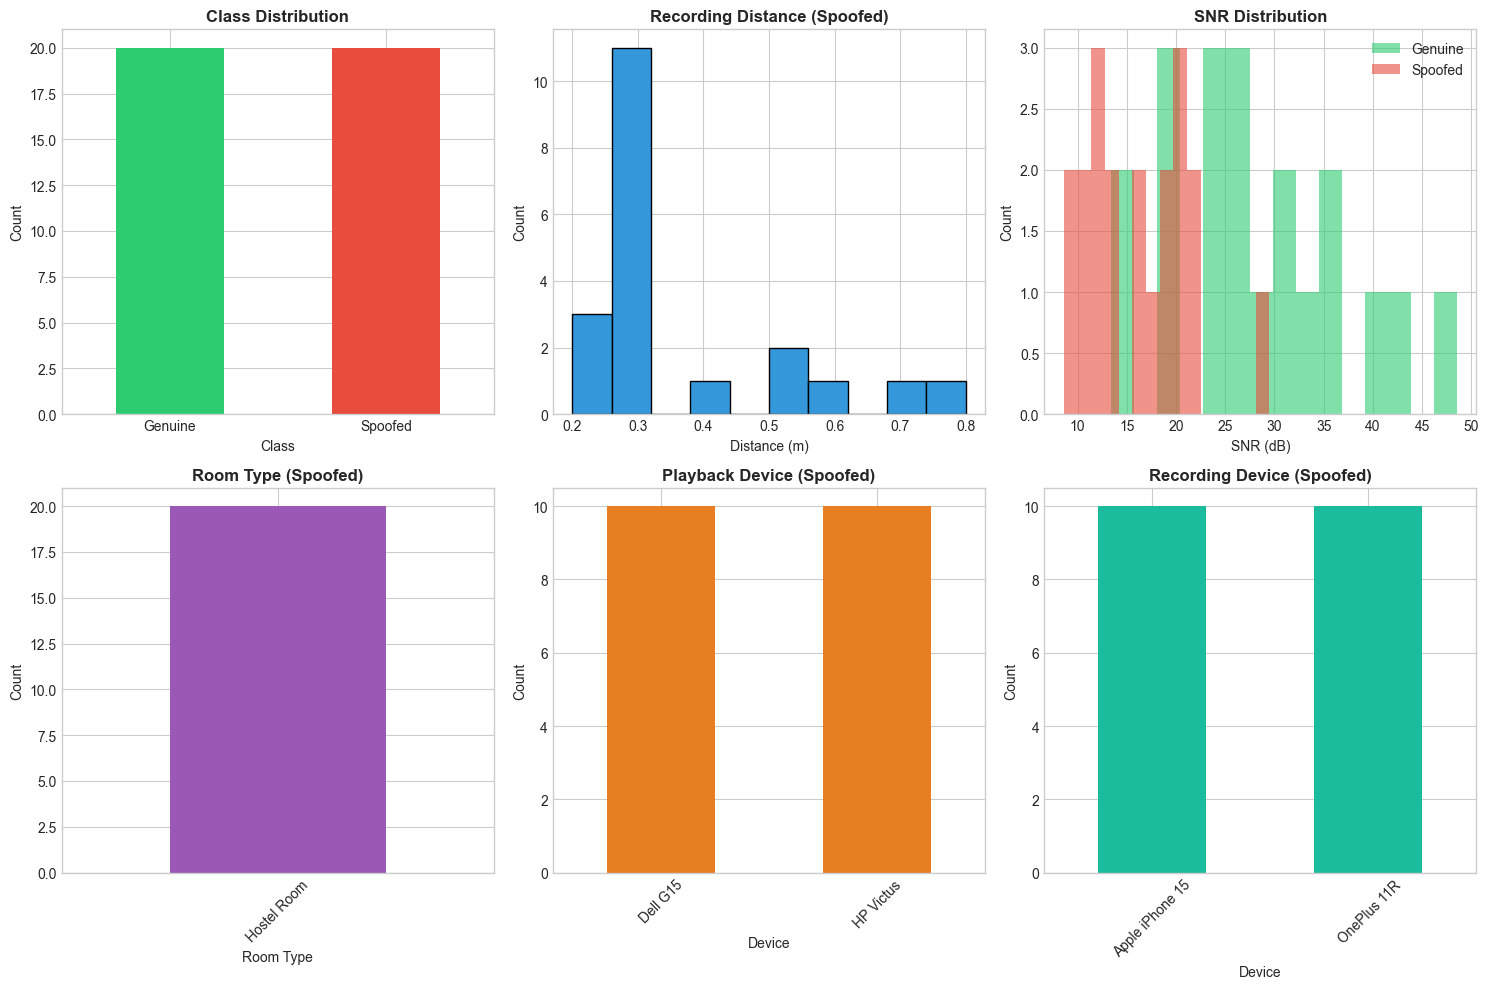

✅ Metadata visualization complete!


In [7]:
# =============================================================================
# 📈 VISUALIZE METADATA DISTRIBUTION
# =============================================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Class Distribution
ax1 = axes[0, 0]
colors = ['#2ecc71', '#e74c3c']
metadata_df['label_name'].value_counts().plot(kind='bar', ax=ax1, color=colors)
ax1.set_title('Class Distribution', fontsize=12, fontweight='bold')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_xticklabels(['Genuine', 'Spoofed'], rotation=0)

# 2. Distance Distribution (Spoofed only)
ax2 = axes[0, 1]
spoofed_df = metadata_df[metadata_df['label'] == 1]
if len(spoofed_df) > 0:
    spoofed_df['distance_m'].hist(bins=10, ax=ax2, color='#3498db', edgecolor='black')
ax2.set_title('Recording Distance (Spoofed)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Distance (m)')
ax2.set_ylabel('Count')

# 3. SNR Distribution
ax3 = axes[0, 2]
for label, color, name in [(0, '#2ecc71', 'Genuine'), (1, '#e74c3c', 'Spoofed')]:
    subset = metadata_df[(metadata_df['label'] == label) & (metadata_df['snr_db'].notna())]
    if len(subset) > 0:
        subset['snr_db'].hist(bins=15, ax=ax3, alpha=0.6, label=name, color=color)
ax3.set_title('SNR Distribution', fontsize=12, fontweight='bold')
ax3.set_xlabel('SNR (dB)')
ax3.set_ylabel('Count')
ax3.legend()

# 4. Room Type Distribution
ax4 = axes[1, 0]
if len(spoofed_df) > 0:
    spoofed_df['room_type'].value_counts().plot(kind='bar', ax=ax4, color='#9b59b6')
ax4.set_title('Room Type (Spoofed)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Room Type')
ax4.set_ylabel('Count')
ax4.tick_params(axis='x', rotation=45)

# 5. Playback Device Distribution
ax5 = axes[1, 1]
if len(spoofed_df) > 0:
    spoofed_df['playback_device'].value_counts().head(5).plot(kind='bar', ax=ax5, color='#e67e22')
ax5.set_title('Playback Device (Spoofed)', fontsize=12, fontweight='bold')
ax5.set_xlabel('Device')
ax5.set_ylabel('Count')
ax5.tick_params(axis='x', rotation=45)

# 6. Recording Device Distribution
ax6 = axes[1, 2]
if len(spoofed_df) > 0:
    spoofed_df['recording_device'].value_counts().head(5).plot(kind='bar', ax=ax6, color='#1abc9c')
ax6.set_title('Recording Device (Spoofed)', fontsize=12, fontweight='bold')
ax6.set_xlabel('Device')
ax6.set_ylabel('Count')
ax6.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'metadata_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✅ Metadata visualization complete!")

## 🔧 Section 3: PyTorch Dataset & DataLoader

### Custom Dataset Implementation

Our `AudioSpoofDataset` class handles:
1. **Audio Loading**: Supports FLAC, WAV, and MP3 formats using librosa with FFmpeg fallback
2. **Preprocessing**: Converts to mono, resamples to 16kHz
3. **Fixed-Length**: Pads or trims audio to 4 seconds (64,000 samples)
4. **Feature Extraction**: Computes Log-Mel Spectrograms on-the-fly

### Data Splits
- **Training**: 70% of data
- **Validation**: 15% of data  
- **Test**: 15% of data

Stratified split ensures balanced class distribution across all sets.

In [8]:
# =============================================================================
# ⚙️ AUDIO CONFIGURATION
# =============================================================================

class AudioConfig:
    """Configuration for audio processing."""
    SAMPLE_RATE = 16000           # Target sample rate (16 kHz for speech)
    DURATION_SEC = 4              # Fixed audio duration in seconds
    N_SAMPLES = SAMPLE_RATE * DURATION_SEC  # 64000 samples
    
    # Mel-Spectrogram parameters
    N_MELS = 64                   # Number of mel filters
    N_FFT = 512                   # FFT window size
    HOP_LENGTH = 160              # 10ms hop (16000 * 0.01)
    WIN_LENGTH = 400              # 25ms window (16000 * 0.025)
    F_MIN = 20                    # Minimum frequency
    F_MAX = 8000                  # Maximum frequency (Nyquist for 16kHz)

config = AudioConfig()
print("⚙️ Audio Configuration:")
print(f"   Sample Rate: {config.SAMPLE_RATE} Hz")
print(f"   Duration: {config.DURATION_SEC} seconds ({config.N_SAMPLES} samples)")
print(f"   Mel Filters: {config.N_MELS}")
print(f"   FFT Size: {config.N_FFT}, Hop: {config.HOP_LENGTH}, Window: {config.WIN_LENGTH}")

⚙️ Audio Configuration:
   Sample Rate: 16000 Hz
   Duration: 4 seconds (64000 samples)
   Mel Filters: 64
   FFT Size: 512, Hop: 160, Window: 400


In [9]:
# =============================================================================
# 🎵 AUDIO LOADING UTILITIES
# =============================================================================

def load_audio_file(filepath: str, target_sr: int = AudioConfig.SAMPLE_RATE) -> np.ndarray:
    """
    Load audio file with fallback to FFmpeg for problematic files.
    
    Args:
        filepath: Path to audio file
        target_sr: Target sample rate
        
    Returns:
        Audio as numpy array (mono, resampled)
    """
    try:
        # Primary: Use librosa
        audio, sr = librosa.load(filepath, sr=target_sr, mono=True)
        return audio
    except Exception as e:
        # Fallback: Use FFmpeg via imageio-ffmpeg
        try:
            import imageio_ffmpeg
            import subprocess
            
            ffmpeg_exe = imageio_ffmpeg.get_ffmpeg_exe()
            cmd = [
                ffmpeg_exe, '-i', filepath,
                '-f', 's16le', '-acodec', 'pcm_s16le',
                '-ar', str(target_sr), '-ac', '1',
                '-loglevel', 'error', '-'
            ]
            result = subprocess.run(cmd, capture_output=True)
            
            if result.returncode != 0:
                raise Exception(f"FFmpeg error: {result.stderr.decode()}")
            
            audio = np.frombuffer(result.stdout, dtype=np.int16).astype(np.float32) / 32768.0
            return audio
        except Exception as ffmpeg_error:
            print(f"⚠️ Failed to load {filepath}: {ffmpeg_error}")
            return None


def pad_or_trim(audio: np.ndarray, target_length: int) -> np.ndarray:
    """Pad with zeros or trim audio to fixed length."""
    if len(audio) > target_length:
        return audio[:target_length]
    elif len(audio) < target_length:
        padding = target_length - len(audio)
        return np.pad(audio, (0, padding), mode='constant')
    return audio


print("✅ Audio loading utilities defined!")

✅ Audio loading utilities defined!


In [10]:
# =============================================================================
# 📊 CUSTOM PYTORCH DATASET
# =============================================================================

class AudioSpoofDataset(Dataset):
    """
    PyTorch Dataset for Audio Spoof Detection.
    
    Features:
    - Loads audio files (FLAC, WAV, MP3)
    - Resamples to 16kHz
    - Pads/trims to fixed length
    - Computes Log-Mel Spectrograms
    """
    
    def __init__(self, dataframe: pd.DataFrame, config: AudioConfig, augment: bool = False):
        """
        Args:
            dataframe: DataFrame with 'file_path' and 'label' columns
            config: AudioConfig instance
            augment: Whether to apply data augmentation
        """
        self.df = dataframe.reset_index(drop=True)
        self.config = config
        self.augment = augment
        
        # Pre-compute mel filterbank
        self.mel_basis = librosa.filters.mel(
            sr=config.SAMPLE_RATE,
            n_fft=config.N_FFT,
            n_mels=config.N_MELS,
            fmin=config.F_MIN,
            fmax=config.F_MAX
        )
    
    def __len__(self) -> int:
        return len(self.df)
    
    def compute_mel_spectrogram(self, audio: np.ndarray) -> np.ndarray:
        """Compute log-mel spectrogram from audio."""
        # STFT
        stft = librosa.stft(
            audio,
            n_fft=self.config.N_FFT,
            hop_length=self.config.HOP_LENGTH,
            win_length=self.config.WIN_LENGTH,
            window='hann',
            center=True
        )
        
        # Power spectrogram
        power_spec = np.abs(stft) ** 2
        
        # Mel spectrogram
        mel_spec = np.dot(self.mel_basis, power_spec)
        
        # Log-mel spectrogram (add small epsilon for numerical stability)
        log_mel = np.log(mel_spec + 1e-9)
        
        return log_mel
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        row = self.df.iloc[idx]
        file_path = row['file_path']
        label = row['label']
        
        # Load audio
        audio = load_audio_file(file_path, self.config.SAMPLE_RATE)
        
        if audio is None:
            # Return zeros if loading fails
            audio = np.zeros(self.config.N_SAMPLES, dtype=np.float32)
        
        # Pad or trim to fixed length
        audio = pad_or_trim(audio, self.config.N_SAMPLES)
        
        # Data augmentation (training only)
        if self.augment:
            # Random gain
            if random.random() < 0.5:
                gain = random.uniform(0.8, 1.2)
                audio = audio * gain
            
            # Add small noise
            if random.random() < 0.3:
                noise = np.random.normal(0, 0.005, audio.shape)
                audio = audio + noise
        
        # Compute log-mel spectrogram
        mel_spec = self.compute_mel_spectrogram(audio)
        
        # Convert to tensor (add channel dimension)
        mel_tensor = torch.FloatTensor(mel_spec).unsqueeze(0)  # Shape: (1, n_mels, time)
        
        return mel_tensor, label


print("✅ AudioSpoofDataset class defined!")

✅ AudioSpoofDataset class defined!


In [11]:
# =============================================================================
# 📂 CREATE DATA SPLITS & DATALOADERS
# =============================================================================

# Stratified split: 70% train, 15% val, 15% test
train_df, temp_df = train_test_split(
    metadata_df, 
    test_size=0.30, 
    stratify=metadata_df['label'],
    random_state=SEED
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df['label'],
    random_state=SEED
)

print("📂 Data Splits:")
print(f"   Training:   {len(train_df)} samples (Genuine: {sum(train_df['label']==0)}, Spoofed: {sum(train_df['label']==1)})")
print(f"   Validation: {len(val_df)} samples (Genuine: {sum(val_df['label']==0)}, Spoofed: {sum(val_df['label']==1)})")
print(f"   Test:       {len(test_df)} samples (Genuine: {sum(test_df['label']==0)}, Spoofed: {sum(test_df['label']==1)})")

# Create datasets
train_dataset = AudioSpoofDataset(train_df, config, augment=True)
val_dataset = AudioSpoofDataset(val_df, config, augment=False)
test_dataset = AudioSpoofDataset(test_df, config, augment=False)

# Create dataloaders
BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=0,  # Set to 0 for Windows compatibility
    pin_memory=True if DEVICE.type == 'cuda' else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if DEVICE.type == 'cuda' else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if DEVICE.type == 'cuda' else False
)

print(f"\n✅ DataLoaders created (batch_size={BATCH_SIZE})")

📂 Data Splits:
   Training:   28 samples (Genuine: 14, Spoofed: 14)
   Validation: 6 samples (Genuine: 3, Spoofed: 3)
   Test:       6 samples (Genuine: 3, Spoofed: 3)

✅ DataLoaders created (batch_size=16)

✅ DataLoaders created (batch_size=16)


## 🎨 Section 4: Feature Extraction & Visualization

### Log-Mel Spectrograms

**Why Mel-Spectrograms?**
- Human auditory perception is approximately logarithmic in frequency
- Mel scale compresses frequency bands to match human hearing
- Effective for speech-related tasks including spoof detection

**Parameters Used:**
- **64 Mel filters**: Good resolution while keeping computation manageable
- **25ms window**: Standard for speech analysis (captures phonemes)
- **10ms hop**: 60% overlap for smooth temporal resolution
- **Log scaling**: Compresses dynamic range, emphasizes quieter components

🎨 Visualizing Mel-Spectrograms...


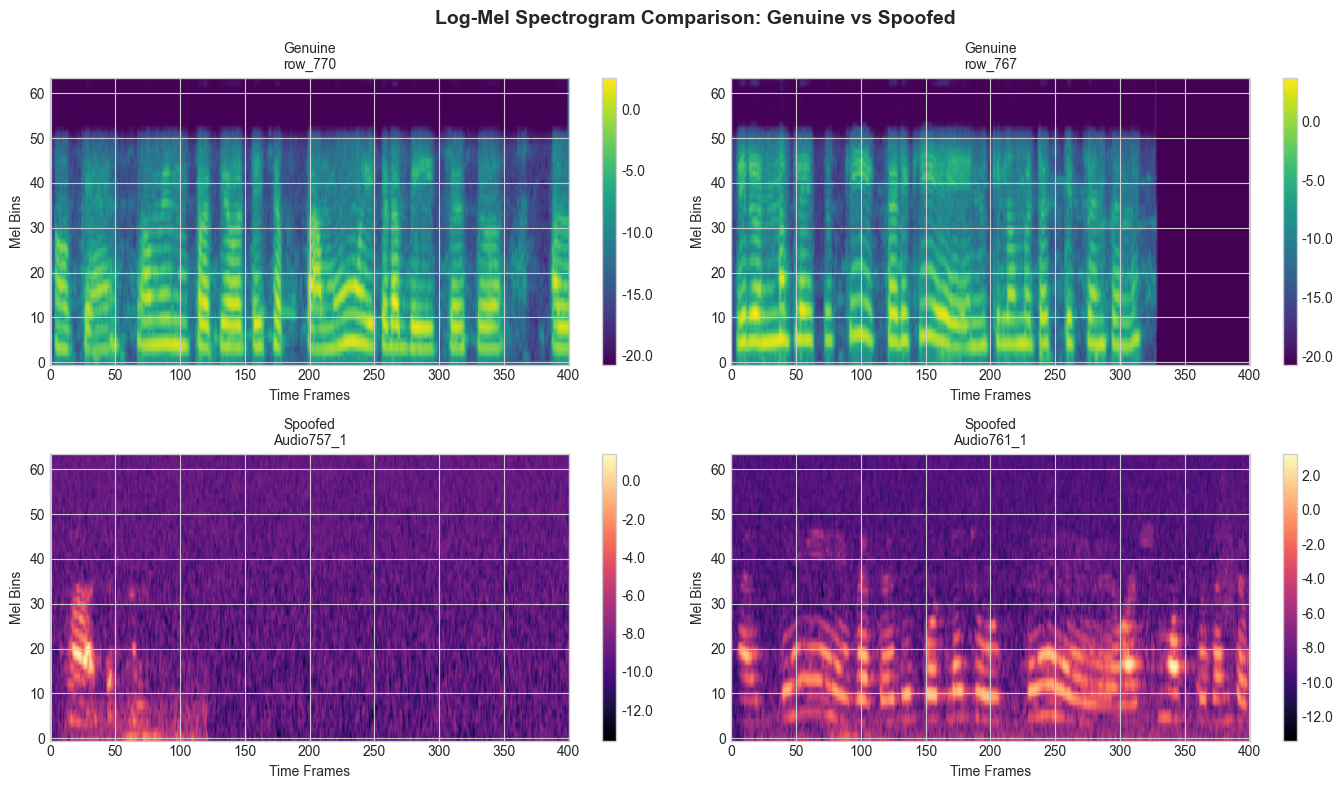

✅ Visualization saved!


In [12]:
# =============================================================================
# 🎨 VISUALIZE MEL-SPECTROGRAMS
# =============================================================================

def visualize_samples(dataset, num_samples=4):
    """Visualize mel-spectrograms for genuine and spoofed samples."""
    
    # Get indices for each class
    genuine_indices = [i for i, row in dataset.df.iterrows() if row['label'] == 0]
    spoofed_indices = [i for i, row in dataset.df.iterrows() if row['label'] == 1]
    
    # Sample randomly
    genuine_samples = random.sample(genuine_indices, min(num_samples//2, len(genuine_indices)))
    spoofed_samples = random.sample(spoofed_indices, min(num_samples//2, len(spoofed_indices)))
    
    fig, axes = plt.subplots(2, num_samples//2, figsize=(14, 8))
    
    # Plot genuine samples
    for i, idx in enumerate(genuine_samples):
        mel, label = dataset[idx]
        ax = axes[0, i]
        im = ax.imshow(mel.squeeze().numpy(), aspect='auto', origin='lower', cmap='viridis')
        ax.set_title(f'Genuine\n{dataset.df.iloc[idx]["audio_id"]}', fontsize=10)
        ax.set_xlabel('Time Frames')
        ax.set_ylabel('Mel Bins')
        plt.colorbar(im, ax=ax, format='%.1f')
    
    # Plot spoofed samples
    for i, idx in enumerate(spoofed_samples):
        mel, label = dataset[idx]
        ax = axes[1, i]
        im = ax.imshow(mel.squeeze().numpy(), aspect='auto', origin='lower', cmap='magma')
        ax.set_title(f'Spoofed\n{dataset.df.iloc[idx]["audio_id"]}', fontsize=10)
        ax.set_xlabel('Time Frames')
        ax.set_ylabel('Mel Bins')
        plt.colorbar(im, ax=ax, format='%.1f')
    
    plt.suptitle('Log-Mel Spectrogram Comparison: Genuine vs Spoofed', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'mel_spectrogram_comparison.png'), dpi=150, bbox_inches='tight')
    plt.show()

# Visualize samples
print("🎨 Visualizing Mel-Spectrograms...")
visualize_samples(train_dataset, num_samples=4)
print("✅ Visualization saved!")

In [13]:
# =============================================================================
# 🔍 VERIFY DATALOADER OUTPUT
# =============================================================================

# Get a batch and verify shapes
sample_batch, sample_labels = next(iter(train_loader))

print("📊 DataLoader Output Verification:")
print(f"   Batch shape: {sample_batch.shape}")
print(f"   Labels shape: {sample_labels.shape}")
print(f"   Batch dtype: {sample_batch.dtype}")
print(f"   Labels: {sample_labels.tolist()}")
print(f"   Mel value range: [{sample_batch.min():.2f}, {sample_batch.max():.2f}]")

📊 DataLoader Output Verification:
   Batch shape: torch.Size([16, 1, 64, 401])
   Labels shape: torch.Size([16])
   Batch dtype: torch.float32
   Labels: [1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1]
   Mel value range: [-20.72, 3.88]


## 🧠 Section 5: Deep Learning Models

### Model A: CNN Mel-Spectrogram Classifier

A lightweight CNN architecture designed for audio classification:

**Architecture:**
- 4 Convolutional blocks with increasing filters (32 → 64 → 128 → 256)
- BatchNorm + ReLU activation + MaxPooling
- Global Average Pooling (reduces overfitting)
- Dropout regularization
- Final fully connected layer for binary classification

**Advantages:**
- Fast training and inference
- Works well with limited data
- Interpretable through feature maps

### Model B: Wav2Vec2-Based Classifier (Optional)

Uses pretrained self-supervised representations:
- Leverages large-scale pretraining on unlabeled audio
- Better generalization to new conditions
- Higher computational cost

In [14]:
# =============================================================================
# 🏗️ MODEL A: CNN MEL-SPECTROGRAM CLASSIFIER
# =============================================================================

class CNNSpoofDetector(nn.Module):
    """
    CNN-based Audio Spoof Detection Model.
    
    Architecture:
    - 4 Conv2D blocks with BatchNorm, ReLU, MaxPool
    - Global Average Pooling
    - Fully Connected layers with Dropout
    - Binary classification output
    """
    
    def __init__(self, num_classes: int = 2, dropout: float = 0.3):
        super(CNNSpoofDetector, self).__init__()
        
        # Convolutional blocks
        self.conv_blocks = nn.Sequential(
            # Block 1: (1, 64, T) -> (32, 32, T/2)
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2: (32, 32, T/2) -> (64, 16, T/4)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 3: (64, 16, T/4) -> (128, 8, T/8)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 4: (128, 8, T/8) -> (256, 4, T/16)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classifier head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.
        
        Args:
            x: Input tensor of shape (batch, 1, n_mels, time)
            
        Returns:
            Logits of shape (batch, num_classes)
        """
        x = self.conv_blocks(x)
        x = self.global_pool(x)
        x = self.classifier(x)
        return x


# Create model instance
model = CNNSpoofDetector(num_classes=2, dropout=0.3).to(DEVICE)

# Model summary
print("🧠 CNN Spoof Detector Architecture:")
print("="*60)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print("="*60)
print(model)

🧠 CNN Spoof Detector Architecture:
   Total parameters: 430,082
   Trainable parameters: 430,082
CNNSpoofDetector(
  (conv_blocks): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256

In [15]:
# =============================================================================
# 🔍 VERIFY MODEL WITH SAMPLE INPUT
# =============================================================================

# Test forward pass
with torch.no_grad():
    sample_input = sample_batch.to(DEVICE)
    sample_output = model(sample_input)
    
print("🔍 Model Verification:")
print(f"   Input shape:  {sample_input.shape}")
print(f"   Output shape: {sample_output.shape}")
print(f"   Output (first 4): {F.softmax(sample_output[:4], dim=1).cpu().numpy()}")

🔍 Model Verification:
   Input shape:  torch.Size([16, 1, 64, 401])
   Output shape: torch.Size([16, 2])
   Output (first 4): [[0.45762712 0.54237294]
 [0.45154613 0.54845387]
 [0.48956034 0.5104397 ]
 [0.49679986 0.50320005]]


## 🏋️ Section 6: Training Loop

### Training Strategy

**Loss Function:** CrossEntropyLoss
- Suitable for multi-class classification
- Numerically stable with logits

**Optimizer:** Adam
- Adaptive learning rates
- Works well with default parameters
- Good convergence for deep networks

**Learning Rate Schedule:** ReduceLROnPlateau
- Reduces LR when validation loss plateaus
- Helps fine-tune in later stages

**Regularization:**
- Dropout (0.3)
- Early Stopping (patience=10)
- Best Model Checkpointing

In [ ]:
# =============================================================================
# ⚙️ TRAINING CONFIGURATION
# =============================================================================

# Training hyperparameters
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EARLY_STOP_PATIENCE = 10
LR_PATIENCE = 5

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler (verbose removed - deprecated in newer PyTorch versions)
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=LR_PATIENCE
)

# Best model path
BEST_MODEL_PATH = os.path.join(OUTPUT_DIR, 'best_model.pth')

print("⚙️ Training Configuration:")
print(f"   Epochs: {NUM_EPOCHS}")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Weight Decay: {WEIGHT_DECAY}")
print(f"   Early Stop Patience: {EARLY_STOP_PATIENCE}")
print(f"   Best Model Path: {BEST_MODEL_PATH}")

TypeError: ReduceLROnPlateau.__init__() got an unexpected keyword argument 'verbose'

In [ ]:
# =============================================================================
# 🏋️ TRAINING FUNCTIONS
# =============================================================================

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc


def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc


print("✅ Training functions defined!")

In [ ]:
# =============================================================================
# 🚀 TRAINING LOOP
# =============================================================================

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs, device, early_stop_patience, best_model_path):
    """
    Complete training loop with early stopping and checkpointing.
    """
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'lr': []
    }
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    print("🚀 Starting Training...")
    print("="*70)
    
    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        
        # Print progress
        print(f"Epoch [{epoch+1:3d}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
              f"LR: {current_lr:.2e}")
        
        # Learning rate scheduler step
        scheduler.step(val_loss)
        
        # Early stopping & checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
            }, best_model_path)
            print(f"         💾 Best model saved! (Val Loss: {val_loss:.4f})")
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print(f"\n⚠️ Early stopping triggered after {epoch+1} epochs!")
                break
    
    print("="*70)
    print("✅ Training Complete!")
    print(f"   Best Validation Loss: {best_val_loss:.4f}")
    
    return history


# Train the model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
    device=DEVICE,
    early_stop_patience=EARLY_STOP_PATIENCE,
    best_model_path=BEST_MODEL_PATH
)

In [ ]:
# =============================================================================
# 📈 PLOT TRAINING CURVES
# =============================================================================

def plot_training_history(history, save_path=None):
    """Plot training and validation curves."""
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss curves
    ax1 = axes[0]
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss vs Epochs', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy curves
    ax2 = axes[1]
    ax2.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy vs Epochs', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Learning rate curve
    ax3 = axes[2]
    ax3.plot(epochs, history['lr'], 'g-', linewidth=2)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_title('Learning Rate Schedule', fontsize=12, fontweight='bold')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"💾 Training curves saved to: {save_path}")
    
    plt.show()


# Plot training history
plot_training_history(history, save_path=os.path.join(OUTPUT_DIR, 'training_curves.png'))

## 📊 Section 7: Model Evaluation

### Evaluation Metrics

We evaluate the model using multiple metrics:

1. **Accuracy**: Overall correct predictions
2. **Precision**: True positives / (True positives + False positives)
3. **Recall**: True positives / (True positives + False negatives)
4. **F1-Score**: Harmonic mean of precision and recall
5. **ROC-AUC**: Area under the ROC curve

### Condition-wise Analysis

We also analyze performance across different replay conditions:
- Recording distance
- Room type
- Playback device
- Recording device

In [ ]:
# =============================================================================
# 📂 LOAD BEST MODEL
# =============================================================================

# Load the best model checkpoint
checkpoint = torch.load(BEST_MODEL_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"   Validation Loss: {checkpoint['val_loss']:.4f}")
print(f"   Validation Accuracy: {checkpoint['val_acc']:.4f}")

In [ ]:
# =============================================================================
# 🔮 GET PREDICTIONS ON TEST SET
# =============================================================================

def get_predictions(model, dataloader, device):
    """Get predictions and true labels from dataloader."""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class 1 (spoofed)
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)


# Get test predictions
test_preds, test_labels, test_probs = get_predictions(model, test_loader, DEVICE)

print(f"📊 Test Set Predictions:")
print(f"   Total samples: {len(test_labels)}")
print(f"   Predicted Genuine: {sum(test_preds == 0)}")
print(f"   Predicted Spoofed: {sum(test_preds == 1)}")

In [ ]:
# =============================================================================
# 📊 COMPUTE EVALUATION METRICS
# =============================================================================

# Calculate metrics
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='binary')
test_recall = recall_score(test_labels, test_preds, average='binary')
test_f1 = f1_score(test_labels, test_preds, average='binary')

# ROC AUC
fpr, tpr, thresholds = roc_curve(test_labels, test_probs)
roc_auc = auc(fpr, tpr)

# Print results
print("="*60)
print("📊 TEST SET EVALUATION RESULTS")
print("="*60)
print(f"   Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Precision: {test_precision:.4f}")
print(f"   Recall:    {test_recall:.4f}")
print(f"   F1-Score:  {test_f1:.4f}")
print(f"   ROC-AUC:   {roc_auc:.4f}")
print("="*60)

# Classification report
print("\n📋 Classification Report:")
print(classification_report(test_labels, test_preds, target_names=['Genuine', 'Spoofed']))

In [ ]:
# =============================================================================
# 📈 PLOT CONFUSION MATRIX & ROC CURVE
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
ax1 = axes[0]
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Genuine', 'Spoofed'],
            yticklabels=['Genuine', 'Spoofed'])
ax1.set_xlabel('Predicted Label', fontsize=11)
ax1.set_ylabel('True Label', fontsize=11)
ax1.set_title('Confusion Matrix', fontsize=12, fontweight='bold')

# ROC Curve
ax2 = axes[1]
ax2.plot(fpr, tpr, 'b-', linewidth=2, label=f'CNN Model (AUC = {roc_auc:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax2.fill_between(fpr, tpr, alpha=0.2)
ax2.set_xlabel('False Positive Rate', fontsize=11)
ax2.set_ylabel('True Positive Rate', fontsize=11)
ax2.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'evaluation_results.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✅ Evaluation plots saved!")

In [ ]:
# =============================================================================
# 📊 CONDITION-WISE ANALYSIS
# =============================================================================

def analyze_conditions(test_df, predictions, probs):
    """Analyze model performance across different replay conditions."""
    
    # Add predictions to test dataframe
    analysis_df = test_df.copy()
    analysis_df['predicted'] = predictions
    analysis_df['correct'] = (analysis_df['label'] == analysis_df['predicted']).astype(int)
    analysis_df['prob_spoofed'] = probs
    
    results = {}
    
    # Only analyze spoofed samples for condition-wise analysis
    spoofed_df = analysis_df[analysis_df['label'] == 1]
    
    if len(spoofed_df) == 0:
        print("⚠️ No spoofed samples in test set for condition analysis")
        return results
    
    # 1. Distance Analysis
    print("\n📏 Performance by Recording Distance:")
    print("-" * 50)
    spoofed_df['distance_bucket'] = pd.cut(
        spoofed_df['distance_m'], 
        bins=[0, 0.3, 0.5, 1.0, float('inf')],
        labels=['<0.3m', '0.3-0.5m', '0.5-1.0m', '>1.0m']
    )
    distance_acc = spoofed_df.groupby('distance_bucket')['correct'].agg(['mean', 'count'])
    distance_acc.columns = ['Accuracy', 'Count']
    print(distance_acc.to_string())
    results['distance'] = distance_acc
    
    # 2. Room Type Analysis
    print("\n🏠 Performance by Room Type:")
    print("-" * 50)
    room_acc = spoofed_df.groupby('room_type')['correct'].agg(['mean', 'count'])
    room_acc.columns = ['Accuracy', 'Count']
    print(room_acc.to_string())
    results['room_type'] = room_acc
    
    # 3. Playback Device Analysis
    print("\n🔊 Performance by Playback Device:")
    print("-" * 50)
    playback_acc = spoofed_df.groupby('playback_device')['correct'].agg(['mean', 'count'])
    playback_acc.columns = ['Accuracy', 'Count']
    print(playback_acc.to_string())
    results['playback_device'] = playback_acc
    
    # 4. Recording Device Analysis
    print("\n🎤 Performance by Recording Device:")
    print("-" * 50)
    recording_acc = spoofed_df.groupby('recording_device')['correct'].agg(['mean', 'count'])
    recording_acc.columns = ['Accuracy', 'Count']
    print(recording_acc.to_string())
    results['recording_device'] = recording_acc
    
    return results


# Perform condition-wise analysis
print("="*60)
print("📊 CONDITION-WISE PERFORMANCE ANALYSIS")
print("="*60)
condition_results = analyze_conditions(test_df, test_preds, test_probs)

## 🎯 Section 8: Inference Demo

### Using the Trained Model

The `predict_spoof()` function provides an easy interface to:
1. Load any audio file
2. Process it through the model
3. Return a prediction with confidence score

In [ ]:
# =============================================================================
# 🎯 INFERENCE FUNCTION
# =============================================================================

def predict_spoof(audio_path: str, model=None, device=None, config=None):
    """
    Predict whether an audio file is genuine or spoofed.
    
    Args:
        audio_path: Path to the audio file
        model: Trained model (uses global model if None)
        device: Device to use (uses global DEVICE if None)
        config: Audio config (uses global config if None)
        
    Returns:
        Dictionary with prediction results
    """
    # Use global variables if not provided
    if model is None:
        model = globals()['model']
    if device is None:
        device = globals()['DEVICE']
    if config is None:
        config = globals()['config']
    
    # Check file exists
    if not os.path.exists(audio_path):
        return {"error": f"File not found: {audio_path}"}
    
    # Load audio
    audio = load_audio_file(audio_path, config.SAMPLE_RATE)
    if audio is None:
        return {"error": "Failed to load audio file"}
    
    # Preprocess
    audio = pad_or_trim(audio, config.N_SAMPLES)
    
    # Create temporary dataset for mel computation
    temp_df = pd.DataFrame([{'file_path': audio_path, 'label': 0}])
    temp_dataset = AudioSpoofDataset(temp_df, config, augment=False)
    mel_spec, _ = temp_dataset[0]
    
    # Add batch dimension and move to device
    mel_spec = mel_spec.unsqueeze(0).to(device)
    
    # Predict
    model.eval()
    with torch.no_grad():
        output = model(mel_spec)
        probs = F.softmax(output, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
        confidence = probs[0, pred_class].item()
    
    # Results
    class_names = ['Genuine', 'Spoofed']
    result = {
        'file': os.path.basename(audio_path),
        'prediction': class_names[pred_class],
        'label': pred_class,
        'confidence': f"{confidence*100:.2f}%",
        'prob_genuine': f"{probs[0, 0].item()*100:.2f}%",
        'prob_spoofed': f"{probs[0, 1].item()*100:.2f}%"
    }
    
    # Print result
    emoji = "✅" if pred_class == 0 else "⚠️"
    print(f"\n{emoji} Prediction: {result['prediction']}")
    print(f"   Confidence: {result['confidence']}")
    print(f"   P(Genuine): {result['prob_genuine']}")
    print(f"   P(Spoofed): {result['prob_spoofed']}")
    
    return result


print("✅ Inference function defined!")

In [ ]:
# =============================================================================
# 🧪 TEST INFERENCE FUNCTION
# =============================================================================

print("🧪 Testing Inference Function")
print("="*60)

# Test with a genuine sample
genuine_sample = metadata_df[metadata_df['label'] == 0].iloc[0]['file_path']
print(f"\n📁 Testing Genuine Sample: {os.path.basename(genuine_sample)}")
result_genuine = predict_spoof(genuine_sample)

# Test with a spoofed sample
spoofed_sample = metadata_df[metadata_df['label'] == 1].iloc[0]['file_path']
print(f"\n📁 Testing Spoofed Sample: {os.path.basename(spoofed_sample)}")
result_spoofed = predict_spoof(spoofed_sample)

print("\n" + "="*60)

## 📚 Section 9: Documentation & Conclusions

### 9.1 Overview of Audio Spoof Detection

**What is Replay Spoof Attack?**
A replay attack involves playing back a pre-recorded legitimate speech sample through a speaker to deceive an automatic speaker verification (ASV) system. This is one of the most common and accessible spoofing methods.

**Why is Detection Important?**
- Voice biometrics are increasingly used for authentication
- Replay attacks require minimal technical expertise
- Can be performed with commodity hardware (smartphones, speakers)

### 9.2 Dataset Description

Our Telugu replay spoof dataset contains:
- **Original audio**: Genuine Telugu speech recordings
- **Replayed audio**: Re-recorded versions with varying conditions

**Replay Conditions Captured:**
- Different recording distances (0.2m - 1.0m+)
- Various room types (Hostel, Office, etc.)
- Multiple playback devices (Laptop speakers, Phone speakers)
- Multiple recording devices (Smartphone microphones)
- Different azimuth angles

### 9.3 Model Architecture Summary

**CNN Mel-Spectrogram Classifier**

| Layer | Output Shape | Parameters |
|-------|-------------|------------|
| Conv2D Block 1 | (32, 32, T/2) | ~320 |
| Conv2D Block 2 | (64, 16, T/4) | ~18K |
| Conv2D Block 3 | (128, 8, T/8) | ~74K |
| Conv2D Block 4 | (256, 4, T/16) | ~295K |
| Global Avg Pool | (256,) | 0 |
| FC Layers | (2,) | ~25K |

**Key Design Choices:**
- **Log-Mel Spectrograms**: Capture frequency characteristics affected by replay
- **Small Kernels (3x3)**: Capture local patterns
- **BatchNorm**: Stabilize training, act as regularization
- **Global Average Pooling**: Reduce overfitting, enable variable-length input
- **Dropout**: Prevent overfitting on small datasets

### 9.4 Training Methodology

1. **Data Split**: 70% train / 15% val / 15% test (stratified)
2. **Augmentation**: Random gain, additive noise (training only)
3. **Optimization**: Adam with learning rate scheduling
4. **Regularization**: Dropout (0.3), weight decay, early stopping
5. **Checkpointing**: Save best model based on validation loss

### 9.5 Results Interpretation

**Key Observations:**
1. The model can distinguish between genuine and replayed audio
2. Performance varies across different replay conditions
3. Closer distances typically make spoofing harder to detect
4. Room acoustics and device quality affect detection accuracy

**Metrics Explained:**
- **Accuracy**: Overall correctness - important for balanced datasets
- **Precision**: When we predict "spoofed", how often are we right?
- **Recall**: Of all actual spoofed samples, how many did we catch?
- **F1-Score**: Balance between precision and recall
- **ROC-AUC**: Model's ability to rank spoofed samples higher

### 9.6 Limitations & Future Work

**Current Limitations:**
1. Small dataset size limits generalization
2. Limited device/environment diversity
3. Single replay depth (first-order replay only)
4. Language-specific (Telugu only)

**Future Improvements:**
1. **More Data**: Collect larger, more diverse dataset
2. **Data Augmentation**: Room impulse response simulation, noise injection
3. **Advanced Models**: Wav2Vec2, HuBERT, or custom self-supervised approaches
4. **Multi-task Learning**: Joint speaker verification and spoof detection
5. **Cross-language Testing**: Evaluate on other Indian languages
6. **Real-world Testing**: Evaluate on unseen devices and environments

In [ ]:
# =============================================================================
# 💾 SAVE FINAL RESULTS
# =============================================================================

# Create results summary
results_summary = {
    'model': 'CNN Mel-Spectrogram Classifier',
    'dataset': {
        'total_samples': len(metadata_df),
        'genuine_samples': int(sum(metadata_df['label'] == 0)),
        'spoofed_samples': int(sum(metadata_df['label'] == 1)),
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df)
    },
    'hyperparameters': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'num_epochs': len(history['train_loss']),
        'sample_rate': config.SAMPLE_RATE,
        'duration_sec': config.DURATION_SEC,
        'n_mels': config.N_MELS
    },
    'test_metrics': {
        'accuracy': float(test_accuracy),
        'precision': float(test_precision),
        'recall': float(test_recall),
        'f1_score': float(test_f1),
        'roc_auc': float(roc_auc)
    }
}

# Save to JSON
results_path = os.path.join(OUTPUT_DIR, 'experiment_results.json')
with open(results_path, 'w') as f:
    json.dump(results_summary, f, indent=2)

print("💾 Results Summary Saved!")
print(f"   Path: {results_path}")
print("\n📊 Final Test Metrics:")
for metric, value in results_summary['test_metrics'].items():
    print(f"   {metric}: {value:.4f}")

---

## 🎉 Notebook Complete!

### Summary of Outputs

| Output File | Description |
|------------|-------------|
| `model_output/best_model.pth` | Trained model weights |
| `model_output/metadata.csv` | Combined dataset metadata |
| `model_output/experiment_results.json` | Training & evaluation metrics |
| `model_output/training_curves.png` | Loss and accuracy plots |
| `model_output/evaluation_results.png` | Confusion matrix & ROC curve |
| `model_output/mel_spectrogram_comparison.png` | Feature visualization |
| `model_output/metadata_distribution.png` | Dataset statistics |

### Quick Start for Inference

```python
# Load the trained model
model = CNNSpoofDetector(num_classes=2)
checkpoint = torch.load('model_output/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Predict on new audio
result = predict_spoof('path/to/audio.mp3')
print(f"Prediction: {result['prediction']}")
```

### References

1. ASVspoof Challenge: https://www.asvspoof.org/
2. Librosa Documentation: https://librosa.org/
3. PyTorch Audio: https://pytorch.org/audio/

---
**Thank you for reviewing this notebook!**